In [ ]:
def string_adapt(val, src='SOURCE', job='node_exporter', interval='1m'): 
    return val.replace('$node', src).replace('$job', job).replace('$__rate_interval', interval)


In [263]:
from prometheus_api_client import PrometheusConnect
import matplotlib.pyplot as plt
import pandas as pd
from time import localtime, mktime

# Connect to Prometheus
prometheus_url = "http://localhost:9090"  # Replace with the URL of your Prometheus server
prom = PrometheusConnect(url=prometheus_url, disable_ssl=True)

# Query processor usage data for the 'node_exporter' job and 'SOURCE' instance

# query = 'sum by(instance) (irate(node_cpu_seconds_total{instance="$node",job="$job", mode="system"}[$__rate_interval])) / on(instance) group_left sum by (instance)((irate(node_cpu_seconds_total{instance="$node",job="$job"}[$__rate_interval])))'
# query = string_adapt(query, interval='15s')
# query = '100 - (avg_over_time(node_cpu_seconds_total{job="node_exporter", instance="SOURCE"}[1m]) * 100)'
query = '(irate(node_cpu_seconds_total{job="node_exporter", instance="SOURCE"}[5m]))'
result = prom.custom_query(query=query)
print(len(result))


32


In [264]:
result_df = pd.DataFrame(columns=['processor', 'time', 'cpu', 'instance', 'job', 'mode'])
met_val_list = [pd.concat([pd.Series(ii['value'], index=['time', 'processor']), pd.Series(ii['metric'])]) for ii in result]
for ii in met_val_list:
    result_df = pd.concat([result_df, ii.to_frame().T])
    
result_df.reset_index(drop=True, inplace=True)
result_df.time = pd.to_datetime(result_df.time, origin="unix", unit="s", utc=True).apply(lambda x: x.tz_convert('America/Fortaleza'))
result_df.processor = result_df.processor.astype(float)
result_df.cpu = result_df.cpu.astype(float)
display(result_df.head())
result_df.info()

,processor,time,cpu,instance,job,mode
0,0.0,2023-10-27 00:10:05.059000015-03:00,4.0,SOURCE,node_exporter,idle
1,0.0,2023-10-27 00:10:05.059000015-03:00,4.0,SOURCE,node_exporter,iowait
2,0.0,2023-10-27 00:10:05.059000015-03:00,4.0,SOURCE,node_exporter,irq
3,0.0,2023-10-27 00:10:05.059000015-03:00,4.0,SOURCE,node_exporter,nice
4,0.0,2023-10-27 00:10:05.059000015-03:00,4.0,SOURCE,node_exporter,softirq


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype                            
---  ------     --------------  -----                            
 0   processor  32 non-null     float64                          
 1   time       32 non-null     datetime64[ns, America/Fortaleza]
 2   cpu        32 non-null     float64                          
 3   instance   32 non-null     object                           
 4   job        32 non-null     object                           
 5   mode       32 non-null     object                           
dtypes: datetime64[ns, America/Fortaleza](1), float64(2), object(3)
memory usage: 1.6+ KB


In [233]:
# Split result_df.time into date and time
result_df['date'] = result_df.time.dt.date
# Time only show hour, minute and second
result_df['time'] = result_df.time.dt.time
# result_df['time'] = pd.to_datetime(result_df['time'], format='%H:%M:%S').dt.time
result_df.head()

,processor,time,cpu,instance,job,mode,date
0,0.993801,23:50:27.183000,4.0,SOURCE,node_exporter,idle,2023-10-26
1,0.000000,23:50:27.183000,4.0,SOURCE,node_exporter,iowait,2023-10-26
2,0.000000,23:50:27.183000,4.0,SOURCE,node_exporter,irq,2023-10-26
3,0.000000,23:50:27.183000,4.0,SOURCE,node_exporter,nice,2023-10-26
4,0.000000,23:50:27.183000,4.0,SOURCE,node_exporter,softirq,2023-10-26


<Axes: ylabel='processor'>

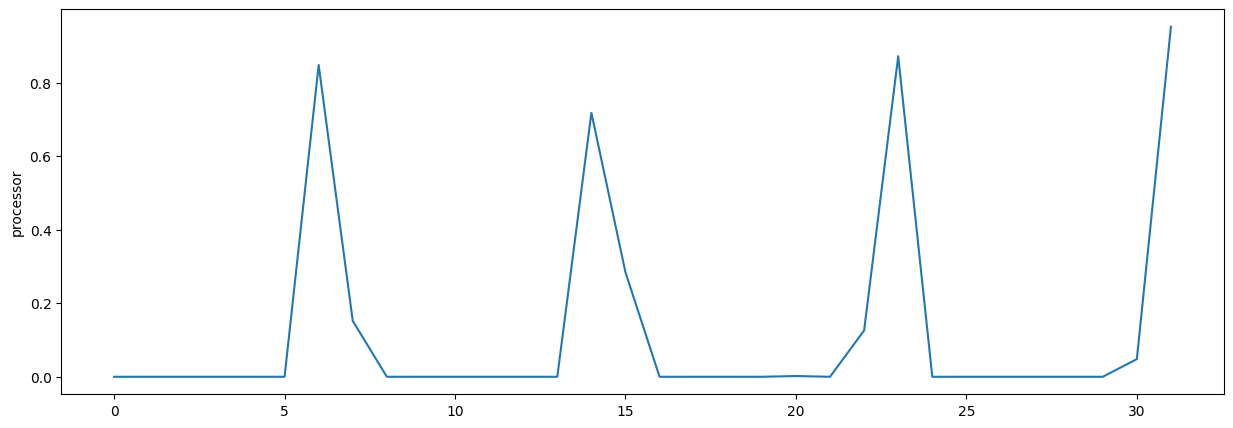

In [265]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(x=range(len(result_df.processor)), y='processor', data=result_df, ax=ax)

In [259]:
result_df.time.max()

Timestamp('2023-10-27 00:09:03.448999882-0300', tz='America/Fortaleza')

In [260]:
result_df.time.min()

Timestamp('2023-10-27 00:09:03.448999882-0300', tz='America/Fortaleza')